In [1]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os
import pickle
import io
from googleapiclient.http import MediaIoBaseDownload

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns 

In [2]:
# Scopes for the Google Drive API
SCOPES = ['https://www.googleapis.com/auth/drive']

def authenticate_google_drive():
    creds = None
    if os.path.exists('./token.pickle'):
        with open('./token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'new_client_id.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('drive', 'v3', credentials=creds)
    return service

drive_service = authenticate_google_drive()

def download_file(file_id, file_name):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(file_name, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Download {int(status.progress() * 100)}%.")

In [3]:
# All the datasets can be found here in this drive folder 
# https://drive.google.com/drive/folders/14J0u4AhUwkfKJKYnJzuD6dRW2y9uZqnD?usp=sharing
# dataset from beer advocate
# downloaded from https://www.kaggle.com/datasets/thedevastator/1-5-million-beer-reviews-from-beer-advocate
file_id = '1039e61fo7FSjobH-u9B-xOT62Abw4GLF'
file_name = 'ba_reviews.csv'
download_file(file_id, file_name)

df = pd.read_csv(file_name)

Download 52%.
Download 100%.


In [4]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   index               1586614 non-null  int64  
 1   brewery_id          1586614 non-null  int64  
 2   brewery_name        1586599 non-null  object 
 3   review_time         1586614 non-null  int64  
 4   review_overall      1586614 non-null  float64
 5   review_aroma        1586614 non-null  float64
 6   review_appearance   1586614 non-null  float64
 7   review_profilename  1586266 non-null  object 
 8   beer_style          1586614 non-null  object 
 9   review_palate       1586614 non-null  float64
 10  review_taste        1586614 non-null  float64
 11  beer_name           1586614 non-null  object 
 12  beer_abv            1518829 non-null  float64
 13  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 169.5+ MB
None
(1

In [5]:
# checking for null values
df.isna().sum()

index                     0
brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

In [6]:
# dropping null values
df.dropna(inplace=True)
df.isnull().sum()

index                 0
brewery_id            0
brewery_name          0
review_time           0
review_overall        0
review_aroma          0
review_appearance     0
review_profilename    0
beer_style            0
review_palate         0
review_taste          0
beer_name             0
beer_abv              0
beer_beerid           0
dtype: int64

In [7]:
df['review_time'] = pd.to_datetime(df.review_time, unit='s')

In [8]:
df['year'] = df.review_time.dt.year

In [9]:
df['review_time'].max(), df['review_time'].min()

(Timestamp('2012-01-11 12:35:48'), Timestamp('1996-08-22 00:00:01'))

In [10]:
df[df.duplicated(['review_profilename', 'beer_name'],keep=False)][:5]

,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,year
187,187,1075,Caldera Brewing Company,2010-08-10 02:34:50,4.0,4.0,4.0,barleywinefiend,American Pale Ale (APA),4.0,4.0,Caldera Pale Ale,5.5,25414,2010
199,199,1075,Caldera Brewing Company,2010-06-22 02:27:01,4.0,3.5,3.5,barleywinefiend,American Pale Ale (APA),3.5,4.0,Caldera Pale Ale,5.5,25414,2010
389,389,1075,Caldera Brewing Company,2010-09-11 20:39:24,4.0,4.0,4.0,barleywinefiend,American IPA,3.5,3.5,Caldera IPA,6.1,10784,2010
426,426,1075,Caldera Brewing Company,2010-06-22 02:22:12,3.5,3.5,4.0,barleywinefiend,American IPA,3.5,3.5,Caldera IPA,6.1,10784,2010
804,804,1075,Caldera Brewing Company,2007-02-14 01:09:21,4.0,3.5,4.0,flexabull,American Amber / Red Ale,4.0,3.5,Ashland Amber,5.4,10785,2007


 ## Dropping duplicate reviews for the same beer by the same user ##

In [11]:
df = df.drop_duplicates(subset=['review_profilename', 'beer_name'], keep='first')

In [12]:
df.describe()

,index,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,year
count,1.496263e+06,1.496263e+06,1.496263e+06,1.496263e+06,1.496263e+06,1.496263e+06,1.496263e+06,1.496263e+06,1.496263e+06,1.496263e+06
mean,7.910775e+05,3.068146e+03,3.822387e+00,3.745287e+00,3.849503e+00,3.752557e+00,3.802741e+00,7.045868e+00,2.143449e+04,2.008330e+03
std,4.590564e+05,5.540524e+03,7.178374e-01,6.956705e-01,6.145845e-01,6.796260e-01,7.291700e-01,2.325997e+00,2.179831e+04,2.399980e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,5.000000e+00,1.998000e+03
25%,3.921155e+05,1.410000e+02,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.655000e+03,2.007000e+03
50%,7.904020e+05,4.140000e+02,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.289500e+04,2.009000e+03
75%,1.187796e+06,2.250000e+03,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.927300e+04,2.010000e+03
max,1.586613e+06,2.800300e+04,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731600e+04,2.012000e+03


/var/folders/5j/c9vk68bx423f99hmd4hy32k80000gn/T/ipykernel_72878/1584983703.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


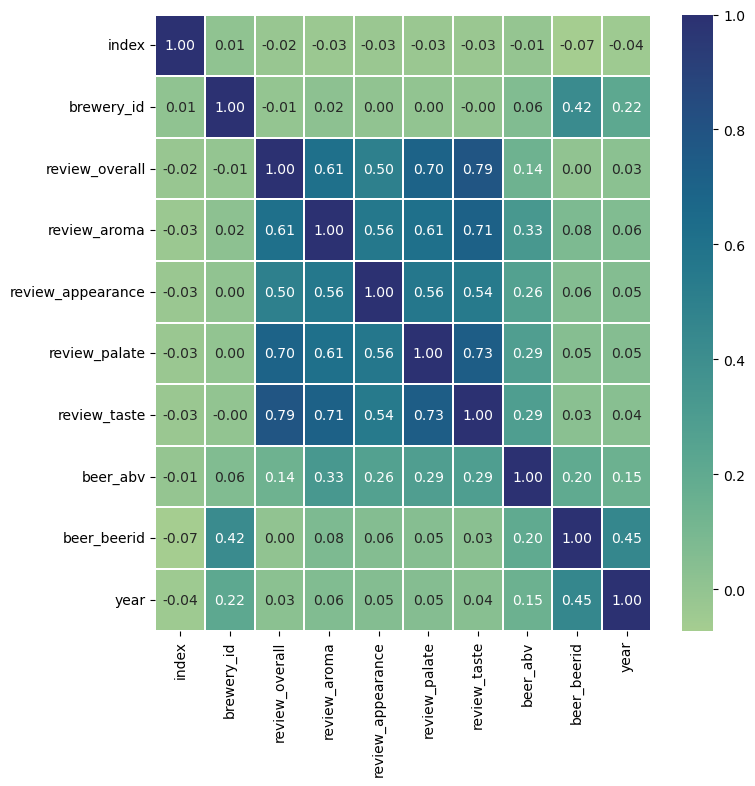

In [13]:
corr = df.corr()
plt.figure(figsize=(8,8))
palette = sns.color_palette("crest", as_cmap=True)
sns.heatmap(corr, annot=True, linewidth=.1, cmap=palette, fmt='.2f')
plt.show()

 - People care more about the taste, than the appearance
 - The review_palate and review_taste have the highest correlation, and review aroma also is highly correlated with the palate and taste

 # User Reviews Exploration

In [14]:
df['review_profilename'].nunique()

32908

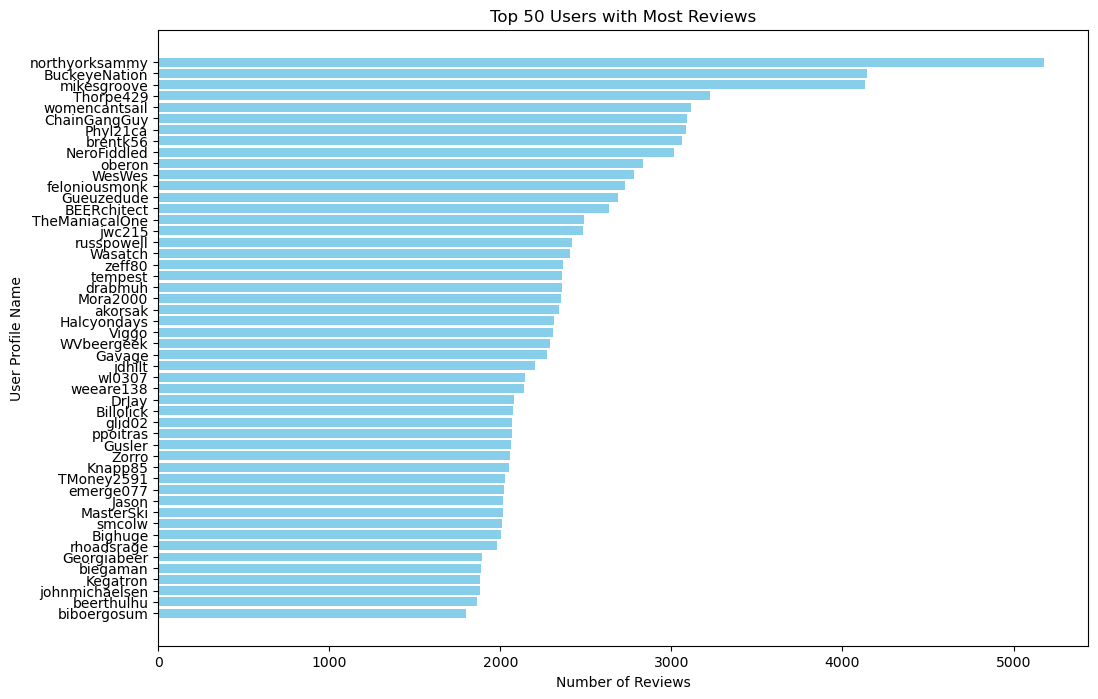

In [15]:
user_review_counts = df.groupby('review_profilename').size().reset_index(name='review_count')

# Sort by review count in descending order and select top 50 users
top_50_users = user_review_counts.sort_values(by='review_count', ascending=False).head(50)

# Plot the data
plt.figure(figsize=(12, 8))
plt.barh(top_50_users['review_profilename'], top_50_users['review_count'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.ylabel('User Profile Name')
plt.title('Top 50 Users with Most Reviews')
plt.gca().invert_yaxis()  # To display the highest number on top
plt.show()

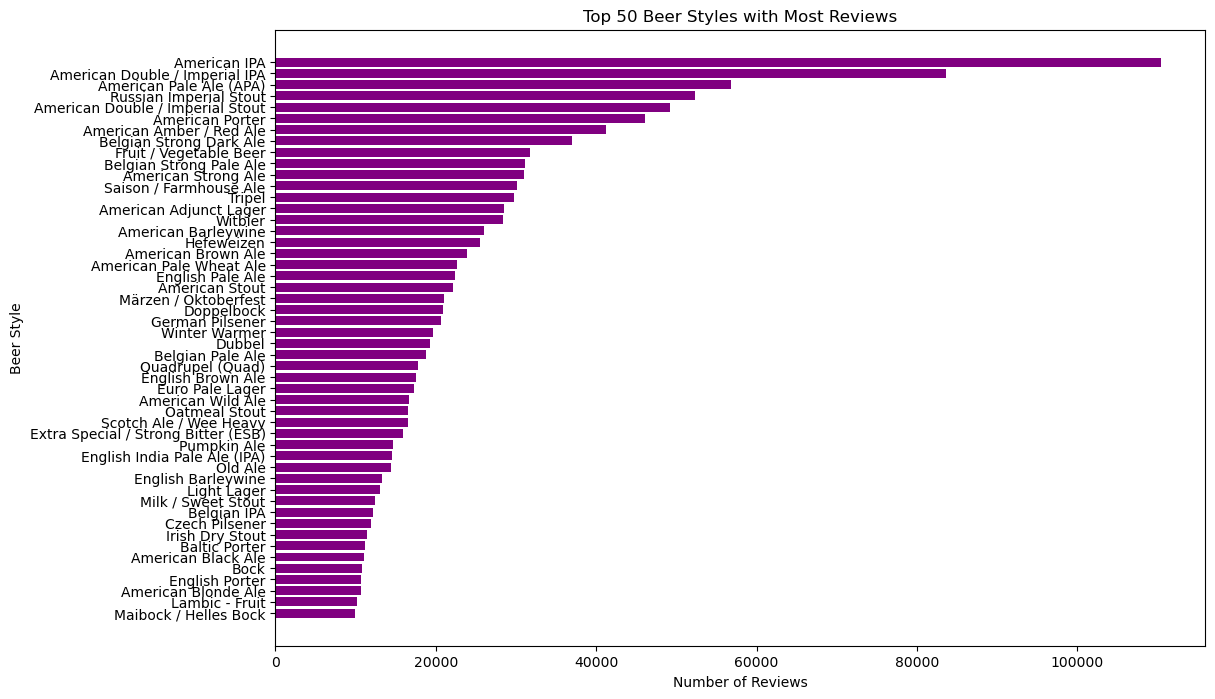

In [16]:
beer_style_counts = df.groupby('beer_style').size().reset_index(name='review_count')

# Sort by review count in descending order and select top 50 users
top_50_beer_styles = beer_style_counts.sort_values(by='review_count', ascending=False).head(50)

# Plot the data
plt.figure(figsize=(12, 8))
plt.barh(top_50_beer_styles['beer_style'], top_50_beer_styles['review_count'], color='purple')
plt.xlabel('Number of Reviews')
plt.ylabel('Beer Style')
plt.title('Top 50 Beer Styles with Most Reviews')
plt.gca().invert_yaxis()  # To display the highest number on top
plt.show()

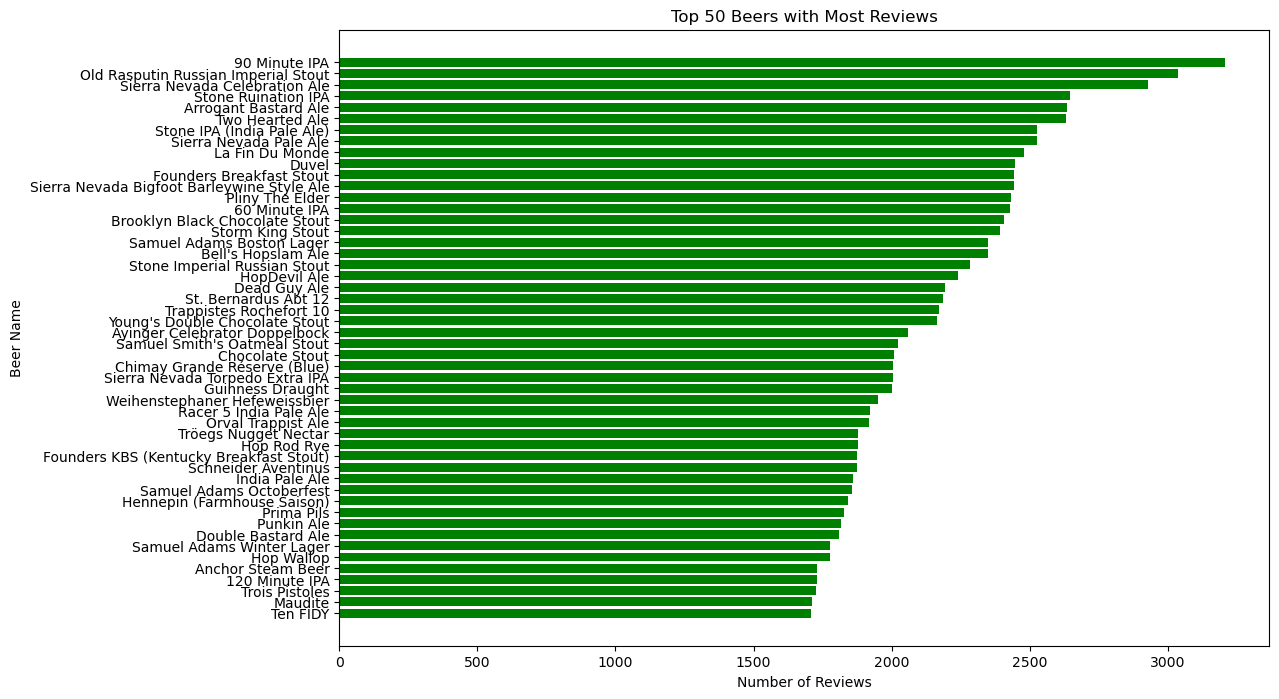

In [17]:
beer_review_counts = df.groupby('beer_name').size().reset_index(name='review_count')

# Sort by review count in descending order and select top 50 users
top_50_beers = beer_review_counts.sort_values(by='review_count', ascending=False).head(50)

# Plot the data
plt.figure(figsize=(12, 8))
plt.barh(top_50_beers['beer_name'], top_50_beers['review_count'], color='green')
plt.xlabel('Number of Reviews')
plt.ylabel('Beer Name')
plt.title('Top 50 Beers with Most Reviews')
plt.gca().invert_yaxis()  # To display the highest number on top
plt.show()

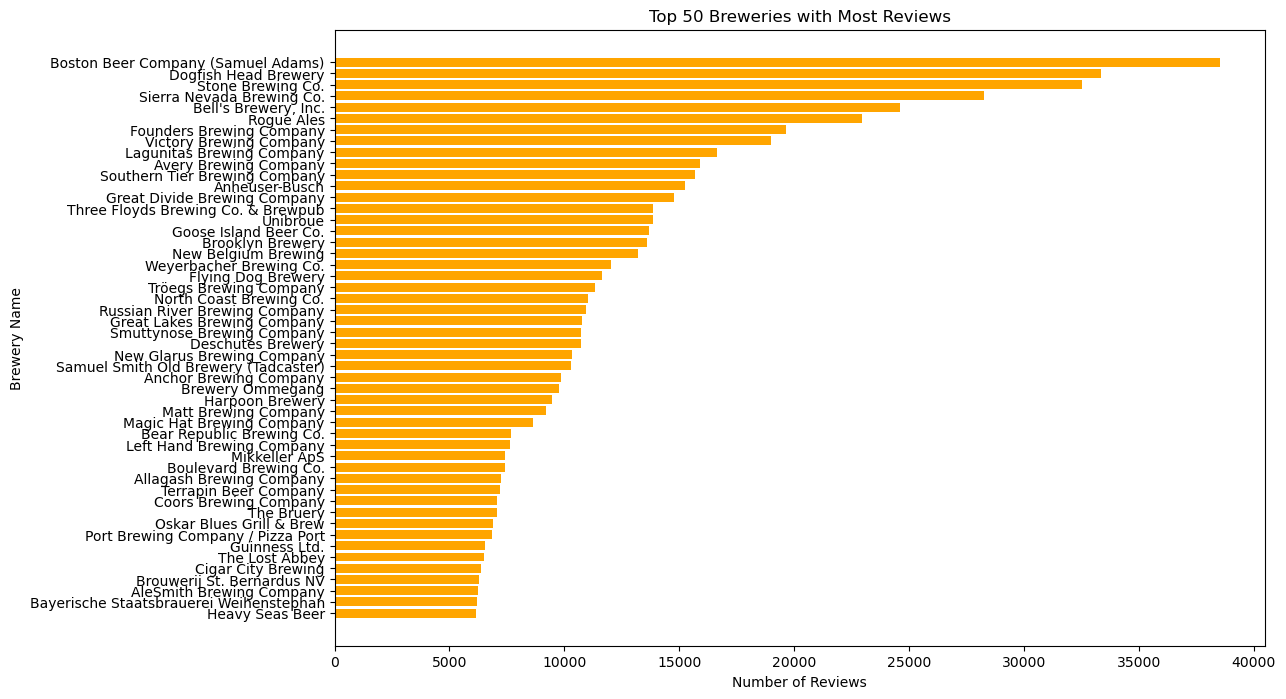

In [18]:
brewery_counts = df.groupby('brewery_name').size().reset_index(name='review_count')

# Sort by review count in descending order and select top 50 users
top_50_breweries = brewery_counts.sort_values(by='review_count', ascending=False).head(50)

# Plot the data
plt.figure(figsize=(12, 8))
plt.barh(top_50_breweries['brewery_name'], top_50_breweries['review_count'], color='orange')
plt.xlabel('Number of Reviews')
plt.ylabel('Brewery Name')
plt.title('Top 50 Breweries with Most Reviews')
plt.gca().invert_yaxis()  # To display the highest number on top
plt.show()

In [19]:
review_counts = pd.DataFrame(df['beer_name'].value_counts())
rare_beers = review_counts[review_counts['beer_name'] < 200].index
common_beers = df[~df['beer_name'].isin(rare_beers)]

 ## Beers with highest rating among beers with 200 reviews or more

In [20]:
common_beers.groupby('beer_name')['review_overall'].agg({'count', 'mean'}).sort_values(by=['mean', 'count'], ascending=[False, False])[:10]  

,mean,count
beer_name,,
Citra DIPA,4.628049,246
Heady Topper,4.618510,443
Trappist Westvleteren 12,4.617925,1272
Pliny The Younger,4.597973,592
Pliny The Elder,4.593544,2432
Founders CBS Imperial Stout,4.592233,618
Live Oak HefeWeizen,4.562893,318
Portsmouth Kate The Great,4.544048,420
Rare Bourbon County Stout,4.542510,247


 ## Beers with lowest rating among beers with 200 reviews or more

In [21]:
common_beers.groupby('beer_name')['review_overall'].agg({'count', 'mean'}).sort_values(by=['mean', 'count'], ascending=[True, False])[:10]  

,mean,count
beer_name,,
Crazy Ed's Cave Creek Chili Beer,1.490602,266
Wild Blue (Blueberry Lager),1.924116,481
Corona Light,1.957227,339
Michelob Ultra,2.148649,518
Miller Chill,2.284741,367
Natural Ice,2.346290,283
Milwaukee's Best Premium,2.351064,235
Samuel Adams Triple Bock,2.358444,604
Bud Ice,2.366000,250


In [22]:
df_style = pd.DataFrame(df['beer_style'].value_counts())
rare_styles = df_style[df_style['beer_style'] < 5000].index
common_beer_styles = df[~df['beer_style'].isin(rare_styles)]

## Beer styles with highest rating among styles with 5000 reviews or more

In [23]:
common_beer_styles.groupby('beer_style')['review_overall'].agg({'count', 'mean'}).sort_values(by=['mean', 'count'], ascending=[False, False])[:10]  

,mean,count
beer_style,,
American Wild Ale,4.098786,16718
Gueuze,4.086610,5900
Quadrupel (Quad),4.072854,17837
American Double / Imperial Stout,4.028935,49214
Russian Imperial Stout,4.024066,52355
Weizenbock,4.010402,9181
American Double / Imperial IPA,3.997716,83632
Flanders Red Ale,3.994775,6507
Rye Beer,3.987334,9514


## Beer styles with lowest rating among styles with 5000 reviews or more

In [24]:
common_beer_styles.groupby('beer_style')['review_overall'].agg({'count', 'mean'}).sort_values(by=['mean', 'count'], ascending=[True, False])[:10]  

,mean,count
beer_style,,
Light Lager,2.684819,13056
American Adjunct Lager,3.006521,28524
Euro Pale Lager,3.204328,17330
American Pale Lager,3.409798,8298
Fruit / Vegetable Beer,3.416756,31774
Herbed / Spiced Beer,3.469135,9914
American Amber / Red Lager,3.573155,8441
American Blonde Ale,3.607776,10712
Pumpkin Ale,3.619433,14661


In [25]:
df_brewery = pd.DataFrame(df['brewery_name'].value_counts())
rare_breweries = df_brewery[df_brewery['brewery_name'] < 2000].index
common_breweries = df[~df['brewery_name'].isin(rare_breweries)]

 ## Breweries with highest rating among breweries with 2000 ratings or more

In [26]:
common_breweries.groupby('brewery_name')['review_overall'].agg({'count', 'mean'}).sort_values(by=['mean', 'count'], ascending=[False, False])[:10]  

,mean,count
brewery_name,,
Brouwerij Westvleteren (Sint-Sixtusabdij van Westvleteren),4.544996,2378
Russian River Brewing Company,4.375160,10934
Bayerische Staatsbrauerei Weihenstephan,4.287508,6212
Brasserie de Rochefort,4.267861,4493
Surly Brewing Company,4.255945,6056
Minneapolis Town Hall Brewery,4.255443,2572
Brouwerij St. Bernardus NV,4.210184,6304
Alpine Beer Company,4.209605,2884
Privatbrauerei Franz Inselkammer KG / Brauerei Aying,4.187595,5256


## Breweries with lowest rating among breweries with 2000 ratings or more

In [27]:
common_breweries.groupby('brewery_name')['review_overall'].agg({'count', 'mean'}).sort_values(by=['mean', 'count'], ascending=[True, False])[:10]  

,mean,count
brewery_name,,
Miller Brewing Co.,2.761679,5480
Anheuser-Busch,2.800046,15226
Grupo Modelo S.A. de C.V.,2.948523,3351
Coors Brewing Company,3.125088,7087
"Cervecería Cuauhtémoc Moctezuma, S.A. de C.V.",3.201284,2725
Pabst Brewing Company,3.272420,3992
Baltika Breweries,3.304848,2042
Jacob Leinenkugel Brewing Company,3.327216,4931
Genesee Brewing Co. / Dundee Brewing Co.,3.384553,3690
